# Final Data Merging & Cleansing & News Paper Sentiment Analysis

## Stage 3 of Data Cleansing

+ In this final stage of Data Cleansing, all the news articles from various sites, were merged into a single excel document
+ This was to pass split the data, remove the stop words, performing lemmatization & sentiment analysis
+ During the analysis, it was kept cognizant that a csv/excel cell can only hold 32767 characters, However, no content exceeded that character length

### Imports, Constants, Parameter Settings

In [31]:
import os
import pickle
import pandas as pd
import numpy as np
import pandas as pd
import re
import warnings
import time
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split # function for splitting data to train and test sets
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [30, 10]


> + Index of the news paper, folder where the content is stored and the csv file

In [3]:
news_papers_data = [
                {'name': 'The_Hindu','folder':'www.thehindu.com','file':'The-Hindu-Extract.csv'},
                {'name': 'Times_of India','folder':'timesofindia.indiatimes.com','file':'TOI-Extract.csv'},
                {'name': 'Business Standard','folder':'www.business-standard.com','file':'Business-Standard-Extract.csv'},
                {'name': 'First Post','folder':'www.firstpost.com','file':'FirstPost-Extract.csv'}  
              ]

In [4]:
news_paper = pd.DataFrame(news_papers_data)
DATA_PATH = 'D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/'

In [5]:
news_paper

,file,folder,name
0,The-Hindu-Extract.csv,www.thehindu.com,The_Hindu
1,TOI-Extract.csv,timesofindia.indiatimes.com,Times_of India
2,Business-Standard-Extract.csv,www.business-standard.com,Business Standard
3,FirstPost-Extract.csv,www.firstpost.com,First Post


> + Code to merge all the news paper content into a single file

In [6]:
i=0
dateparse = lambda x: pd.datetime.strptime(x, '%d-%m-%Y')
full_paper_links = pd.DataFrame(columns=['seq_no','site','link','date-published-updated','news_text'])
paper_links = pd.DataFrame(columns=['seq_no','site','link','date-published-updated'])
for i in range(len(news_paper)):
    paper_links = pd.read_csv(DATA_PATH+news_paper['file'][i],parse_dates=['date-published-updated'], date_parser=dateparse)
    #print(paper_links.dtypes)
    paper_links.columns=['seq_no','site','link','date-published-updated']
    i1 = 1
    x = 0
    for x in range(len(paper_links)):
        text_read = open(os.path.join(DATA_PATH+news_paper['folder'][i],str(i1)+".txt"),'r',encoding='utf8')
        str_text = '' 
        for line in text_read:
            str_text = str_text+str(line)
        print(os.path.join(DATA_PATH+news_paper['folder'][i],str(i1)+".txt")+':'+str(len(str_text)))
        if(len(str_text)>30000):
            print(str(len(str_text))+':'+os.path.join(DATA_PATH+news_paper['folder'][i],str(i1)+".txt"))
        full_paper_links = full_paper_links.append({'seq_no':paper_links['seq_no'][x],
                                                    'site':paper_links['site'][x],
                                                    'link':paper_links['link'][x],
                                                    'date-published-updated':paper_links['date-published-updated'][x],
                                                    'news_text':str(str_text).strip()
                                                   },ignore_index=True)
        i1 = i1 + 1
full_paper_links['date-published-updated'] = pd.to_datetime(full_paper_links['date-published-updated']).apply(lambda x: x.date())
full_paper_links = full_paper_links.sort_values(by=['date-published-updated'])
full_paper_links.to_csv(DATA_PATH+'Full_news_article.csv',encoding='utf8')

D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\1.txt:7629
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\2.txt:11238
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\3.txt:7558
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\4.txt:4906
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\5.txt:3577
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\6.txt:2917
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\7.txt:6050
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\8.txt:2951
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\9.txt:3154
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.com\10.txt:3202
D:/iCloudDrive/ISB/Term1/PRAT/Demonetization_Sentiment_Analysis/www.thehindu.c

## Cleansing/Lemmatizing Data for Further Sentiment Analysis

> + Removing links from the news paper content
> 
> + Removing Special Characters & double spacing
>

In [7]:
import re
full_paper_links['news_text']=full_paper_links['news_text'].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', ' ', x.lower()))
full_paper_links['news_text']=full_paper_links['news_text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
full_paper_links['news_text'] = full_paper_links['news_text'].apply(lambda x: re.sub('  ', ' ', x)) 

> + **Step 1** : Using the WordNet Lemmatizer for finding the words/sentences
>
> + **Step 2** : Using a TfidfVectorizer to vectorize the data
> 
> + **Step 3** : Vectorized Data was passed to SentimentIntensityAnalyzer, for every newspaper content.
>  
> + **Step 4** : Storing the compound polarity, neutral, positive, negative polarity scores & classifying them into sentiment types.

In [8]:
full_paper_links['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in full_paper_links['news_text']]       
vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
X = vectorizer.fit_transform(full_paper_links['text_lem'].str.upper())
sid = SentimentIntensityAnalyzer()
full_paper_links['sentiment_compound_polarity']=full_paper_links.text_lem.apply(lambda x:sid.polarity_scores(x)['compound'])
full_paper_links['sentiment_neutral']=full_paper_links.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])
full_paper_links['sentiment_negative']=full_paper_links.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
full_paper_links['sentiment_pos']=full_paper_links.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
full_paper_links['sentiment_type']=''
full_paper_links.loc[full_paper_links.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
full_paper_links.loc[full_paper_links.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
full_paper_links.loc[full_paper_links.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

> **Creating a field for month**

In [9]:
full_paper_links['month'] = pd.to_datetime(full_paper_links['date-published-updated']).dt.strftime('%m/%Y')

In [10]:
full_paper_links['month']  = pd.to_datetime(full_paper_links['month'], format="%m/%Y")

> **Grouping the news sentiment types by Month & Sentiment Type**

In [11]:
fp_month = full_paper_links
fp_month=full_paper_links.groupby(['month','sentiment_type'])\
    .agg({'sentiment_type':'count','sentiment_negative':'sum','sentiment_neutral':'sum','sentiment_pos':'sum'
         })\
    .rename(columns={'sentiment_type':'sent_count',
                     'sentiment_negative':'neg_sent_total',
                     'sentiment_neutral':'neu_sent_total',
                     'sentiment_pos':'pos_sent_total'
                    })\
    .reset_index()

In [12]:
fp_month.set_index('month',inplace=True)

In [13]:
fp_month

,sentiment_type,sent_count,neg_sent_total,neu_sent_total,pos_sent_total
month,,,,,
2016-11-01,NEGATIVE,2,0.230,1.590,0.180
2016-11-01,NEUTRAL,2,0.000,0.000,0.000
2016-11-01,POSITIVE,4,0.324,3.278,0.398
2016-12-01,NEGATIVE,1,0.106,0.790,0.104
2016-12-01,NEUTRAL,1,0.000,0.000,0.000
2016-12-01,POSITIVE,5,0.353,4.058,0.591
2017-01-01,NEGATIVE,2,0.274,1.538,0.189
2017-02-01,NEGATIVE,1,0.082,0.835,0.083
2017-02-01,POSITIVE,1,0.073,0.837,0.090


In [14]:
x=fp_month[fp_month['sentiment_type']=='NEGATIVE']
neg=fp_month[fp_month['sentiment_type']=='NEGATIVE']['sent_count']
neu=fp_month[fp_month['sentiment_type']=='NEUTRAL']['sent_count']
pos=fp_month[fp_month['sentiment_type']=='POSITIVE']['sent_count']

In [15]:
negd = pd.DataFrame({'month':neg.index,'neg_sent_count':neg.values})
negd.set_index('month',inplace=True)
neud = pd.DataFrame({'month':neu.index,'neu_sent_count':neu.values})
neud.set_index('month',inplace=True)
posd = pd.DataFrame({'month':pos.index,'pos_sent_count':pos.values})
posd.set_index('month',inplace=True)
merged = negd.join([neud,posd],how='outer').fillna(0).reset_index()

> + ** Below is a graph of how positive, negative and neutral articles over the news articles**
> + **It could be found that the negative & positive comments are almost the same since the time of demonetization, However during the anniversary of demonetization there were positive sentiments in the news articles**


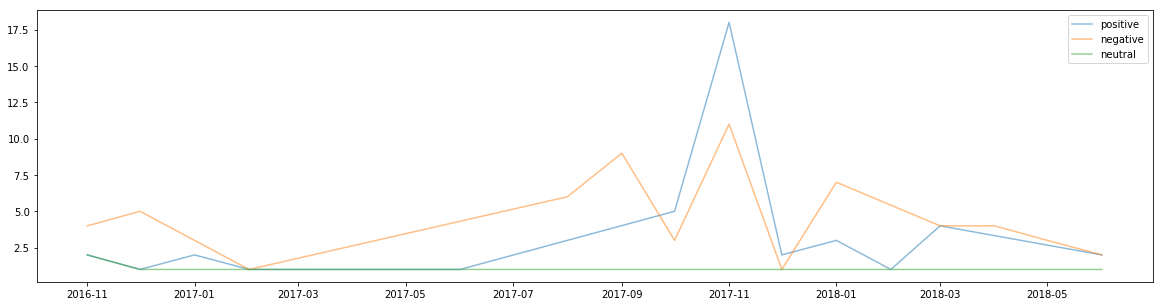

In [30]:
plt.figure(figsize=(20,5))
plt.plot(negd,alpha=0.5,label='positive')
plt.plot(posd,alpha=0.5,label='negative')
plt.plot(neud,alpha=0.5,label='neutral')

#plt.hist(neu,alpha=0.5,label='neutral')
plt.legend(loc='upper right')
plt.show()

In [16]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


> + **In continuation to the previous, below bar graph seconds the opinion that in general has been a positive and negative (comments) at the same level. **
>
> + ** However during the anniversary of the demonetization, there were many articles published. Which echoed a negative sentiment on the demonetization ** 

[Text(0,0,'Nov-2016'),
 Text(0,0,'Dec-2016'),
 Text(0,0,'Jan-2017'),
 Text(0,0,'Feb-2017'),
 Text(0,0,'Jun-2017'),
 Text(0,0,'Aug-2017'),
 Text(0,0,'Sep-2017'),
 Text(0,0,'Oct-2017'),
 Text(0,0,'Nov-2017'),
 Text(0,0,'Dec-2017'),
 Text(0,0,'Jan-2018'),
 Text(0,0,'Feb-2018'),
 Text(0,0,'Mar-2018'),
 Text(0,0,'Apr-2018'),
 Text(0,0,'May-2018'),
 Text(0,0,'Jun-2018')]

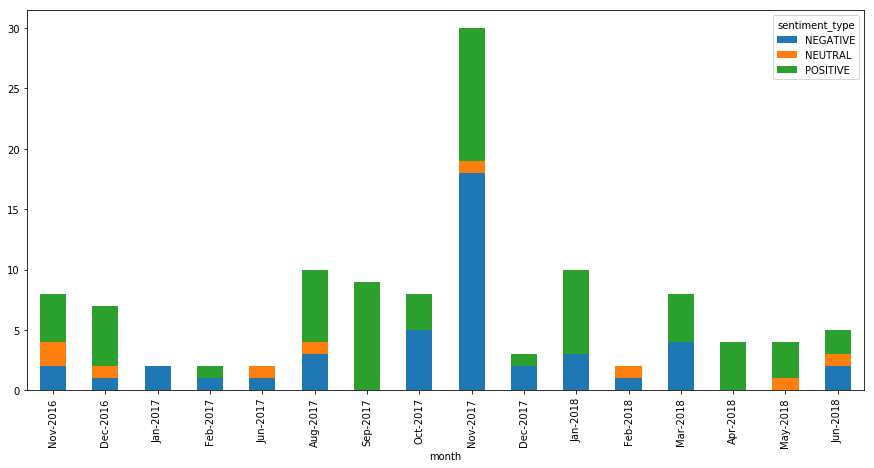

In [22]:
fp_month['month'] = pd.to_datetime(fp_month.index, format="%m/%Y")
fp_month = fp_month.sort_values(by=['month'])
fp_month.set_index(fp_month['month'],inplace=True)
ax = fp_month.set_index('sentiment_type',append=True)['sent_count'].unstack().plot.bar(stacked=True,figsize=(15,7))
ax.set_xticklabels(fp_month.month.apply(lambda x:datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').strftime('%b-%Y')).unique().tolist())


## WordCloud on Training Data

> + **Credit: https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis/notebook**

> + ** Below code is to create a dataframe of cleaned news paper content, following techniques are applied to clean the content** 
    + ** Remove any tweet references in the news articles (hash tags, handles, Retweets) **
> 
> + ** Created a training and test set of the data, for creating a wordcloud**
>      + ** Training set was created to see if there are any unwanted stop words that were included.** 
>      + ** It was during the training set, we observed that java script code was present in the text content and we had to remove the same **
>
> + ** Below pics show the positive & negative sentiment wordclouds **

In [23]:
df_bow= full_paper_links[['text_lem','sentiment_type']]

54
Positive words


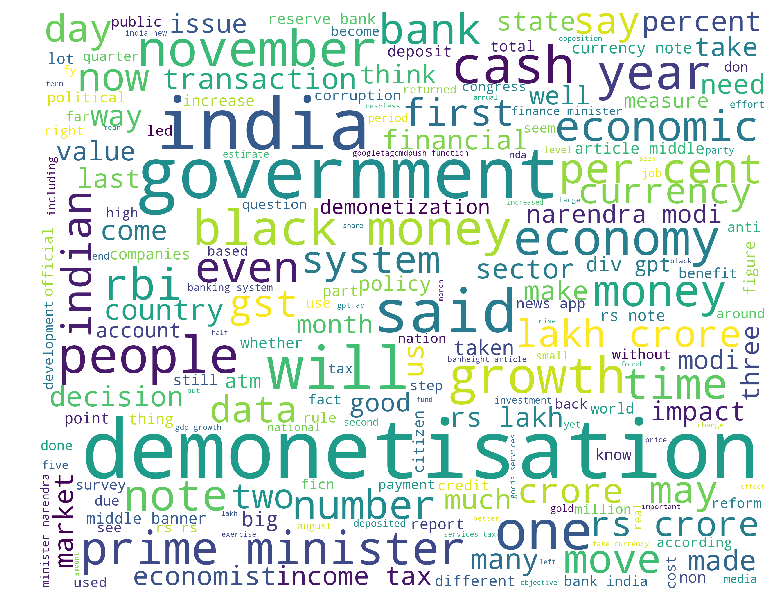

Negative words


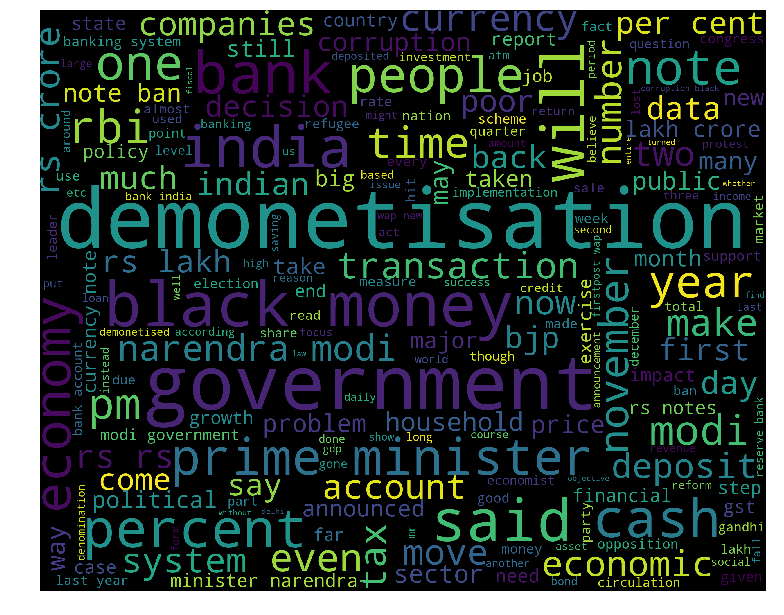

In [24]:
# Splitting the dataset into train and test set
train, test = train_test_split(df_bow,test_size = 0.1)
train = train[train.sentiment_type != "Neutral"]
train_pos = train[ train['sentiment_type'] == 'POSITIVE']
train_pos = train_pos['text_lem']
print(len(train_pos))
train_neg = train[ train['sentiment_type'] == 'NEGATIVE']
train_neg = train_neg['text_lem']
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                            and not word.startswith('@')
                            and not word.startswith('#')
                            and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

## WordCloud on Full Data & Frequency Distribution of Words

> + **After the cleanup of the full text corpus, wordcloud was generated on the full data ** 
>
> + **Apart from the wordcloud, frequency distribution of all the text corpus was generated. It was interesting to note an almost perfect elbow curve in the usage word - text corpus **

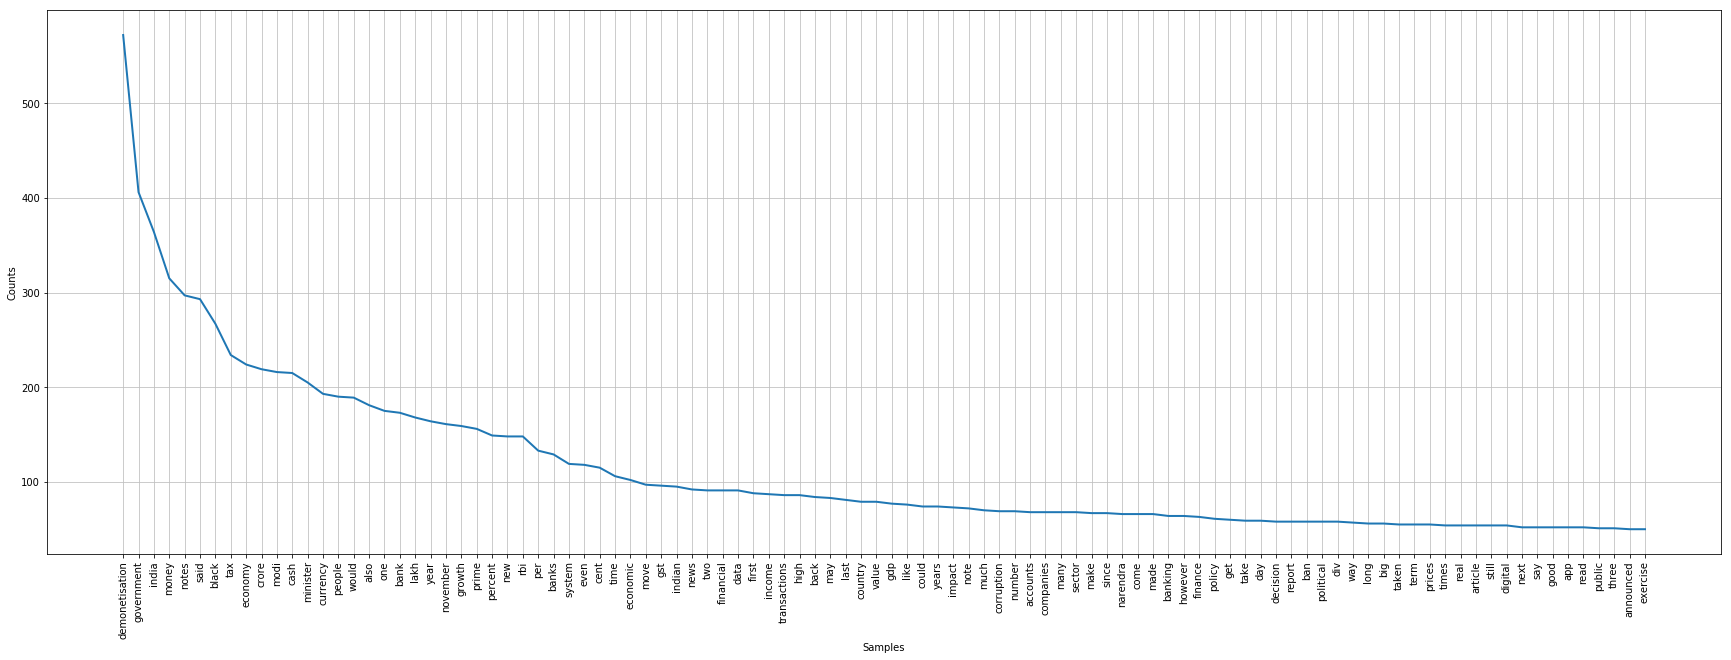

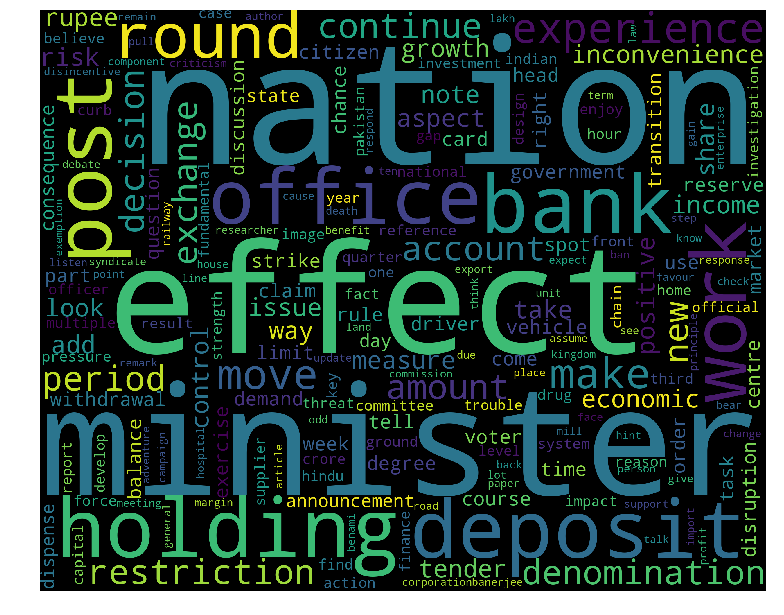

In [32]:
from nltk.corpus import stopwords
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in df_bow.iterrows():
    words_filtered = [e.lower() for e in row.text_lem.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords,row.sentiment_type))

def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    wordlist.plot(100)
    wordlist.pformat
    #x = wordlist.most_common(100)
    #wordlist.plot()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

wordcloud_draw(w_features)
